# Imports

In [1]:
# data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
# model
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

# Load Data

In [2]:
data = pd.read_csv('titanic.csv')

In [3]:
data.shape

(891, 12)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Dataset has 12 columns. Total 11 features and 1 target label.

In [5]:
y = data.Survived
X = data.drop('Survived', axis=1)

Do train test split before preprocessing the data. Should not see the test data until the final stage.

In [6]:
def train_validate_test_split(X, y, *args, **kwargs):  
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, *args, **kwargs)    
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, *args, **kwargs)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(X, y, random_state=42)

In [8]:
print([item.shape for item in (X_train, X_val, X_test, y_train, y_val, y_test)])

[(501, 11), (167, 11), (223, 11), (501,), (167,), (223,)]


# Preview

Analysis the missing values and unique values

In [9]:
def show_missing_info(data):
    return pd.DataFrame({
        'isnull': data.isnull().sum(),
        'nunique': data.nunique(),
        'dtypes': data.dtypes,
    })

In [10]:
show_missing_info(X_train)

,isnull,nunique,dtypes
PassengerId,0,501,int64
Pclass,0,3,int64
Name,0,501,object
Sex,0,2,object
Age,97,79,float64
SibSp,0,7,int64
Parch,0,6,int64
Ticket,0,409,object
Fare,0,181,float64
Cabin,387,89,object


`Name`, `Ticket` and `Cabin` are categorical having too many unique value, therefore should be dropped.

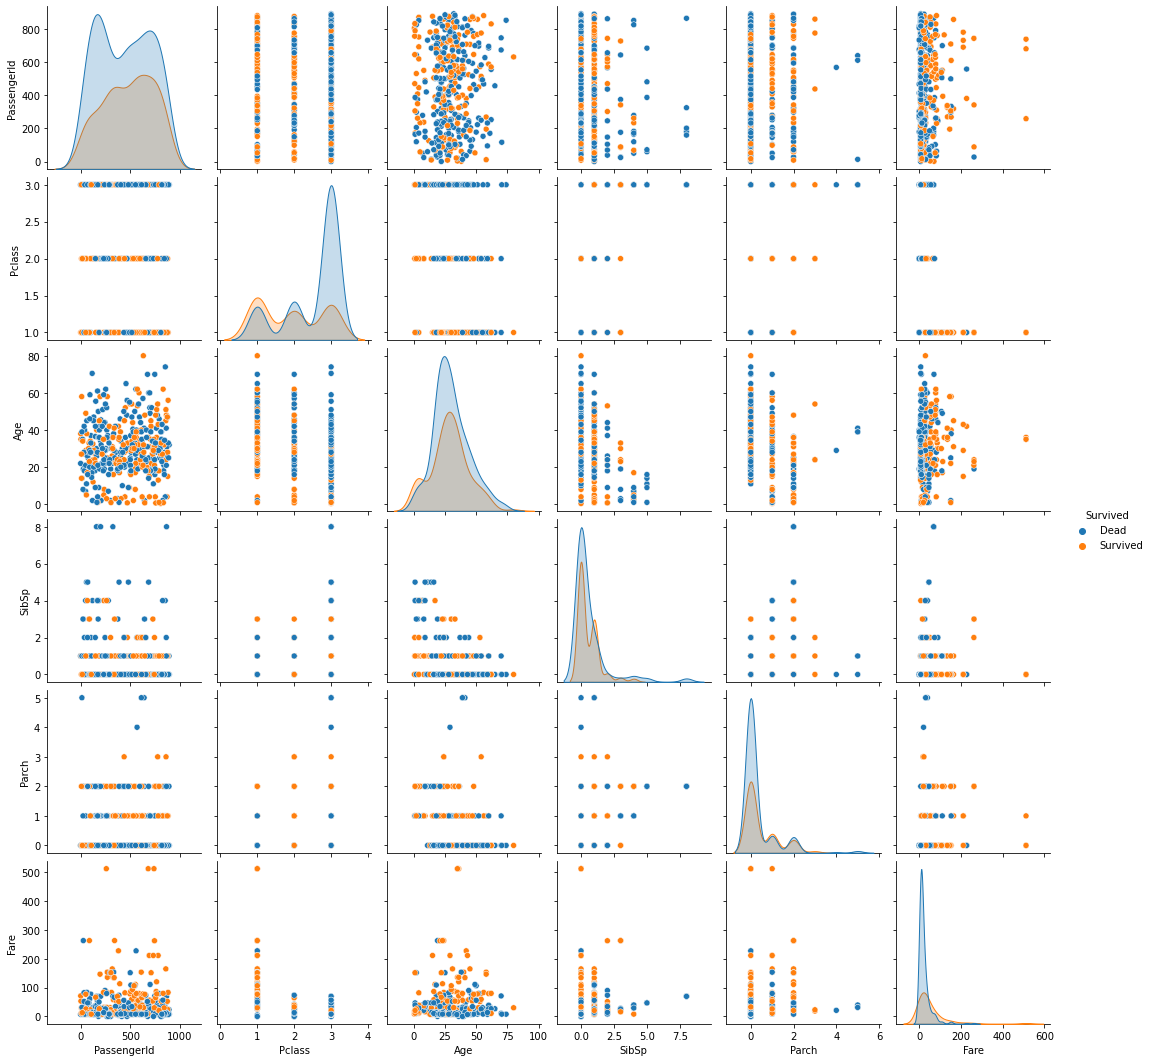

In [11]:
sns.pairplot(X_train.join(y_train.apply(lambda x: 'Survived' if x else 'Dead')), hue='Survived')

# Preprocessing

In [12]:
# Select categorical columns
categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].nunique() < 10 and X_train[cname].dtype == "object"]
# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]
selected_cols = categorical_cols + numerical_cols

In [13]:
selected_cols

['Sex', 'Embarked', 'PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Only keep categorical columns having less than 10 unique values.

In [14]:
X_train, X_val, X_test = X_train[selected_cols], X_val[selected_cols], X_test[selected_cols]

In [15]:
print([_.shape for _ in (X_train, X_val, X_test, y_train, y_val, y_test)])

[(501, 8), (167, 8), (223, 8), (501,), (167,), (223,)]


# Model

In [16]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [17]:
column_transformer = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [18]:
model = RandomForestClassifier(n_estimators=100)

In [19]:
classifier = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('model', model),
])

In [20]:
classifier.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['PassengerId', 'Pclass',
                                                   'Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('model', RandomForestClassifier())])

In [21]:
y_val_pred = classifier.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

In [22]:
print(f'Validation Accuracy: {val_acc:.2%}')

Validation Accuracy: 80.24%


# Evaluation 

In [23]:
y_test_pred = classifier.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

In [24]:
print(f'Test Accuracy: {test_acc:.2%}')

Test Accuracy: 80.72%


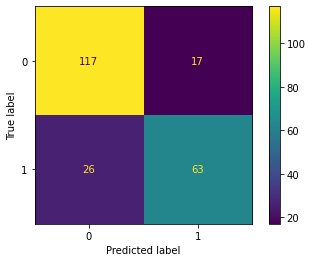

In [25]:
plot_confusion_matrix(classifier, X_test, y_test)

# Application

In [26]:
def application(idx=None):
    if idx is None:
        idx = np.random.randint(len(X_test))
    print('Collected new features as follows:')
    print(X_test.iloc[idx])
    names = lambda x: 'Survived' if x else 'Dead'
    forecasted = classifier.predict(X_test.iloc[idx:idx+1])[0]
    actual = y_test.iloc[idx]
    print(f'\n{"CORRECT" if forecasted==actual else "WRONG"}')
    print(f'\nModel forecasted as {forecasted} ({names(forecasted)})')
    print(f'\nActual data should be {actual} ({names(actual)})')

In [27]:
application()

Collected new features as follows:
Sex            female
Embarked            Q
PassengerId       360
Pclass              3
Age               NaN
SibSp               0
Parch               0
Fare           7.8792
Name: 359, dtype: object

CORRECT

Model forecasted as 1 (Survived)

Actual data should be 1 (Survived)
